In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
import scipy.stats
import pandas as pd
from sklearn import preprocessing
import statistics
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

c:\Users\OmarAbdelgawad\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\OmarAbdelgawad\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\OmarAbdelgawad\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
#defining some paths and feature size
IRF_filename = 'dataset used for training/IRF NL 955 rpm.csv'
BF_filename = 'dataset used for training/BF NL 945 rpm.csv'
array_feature_size = 800

In [3]:
#These are some utility functions that I used
def find_time_step(time_vector:np.ndarray)->float:
    """Finds the discrete step size of the time vector.
    
    Args:
        time_vector(np.ndarray): 1 dimensional array of time that has a const time_step.
    
    Returns:
        float: average discrete time step of the array.
    """
    # timef = time_vector[0]
    # timel = time_vector[1]
    avg_time_step = statistics.mean(np.diff(time_vector))
    return avg_time_step

def decompose_from_filename(filename:str):
    df = pd.read_csv(filename)
    time_vec = np.array(df.iloc[:,0])
    signal = np.array(df.iloc[:,1])
    return time_vec, signal

def fft_filter(signal_fft, sample_freq, threshold):
    signal_fft_copy = signal_fft.copy()
    indices_to_zero = np.abs(sample_freq) > threshold
    signal_fft_copy[indices_to_zero] = 0
    filtered_signal = np.fft.ifft(signal_fft_copy).real
    return signal_fft_copy, filtered_signal

def feature_extraction(filtered_signal_reshaped, IRF):
    rms_array = np.sqrt(np.mean(filtered_signal_reshaped**2,axis=1))
    skew_array = scipy.stats.skew(filtered_signal_reshaped, axis=1)
    mean_array = np.mean(filtered_signal_reshaped, axis=1)
    std_array = np.std(filtered_signal_reshaped,axis=1,ddof=1) #highly corr
    amplitude_square_array = np.sum(filtered_signal_reshaped**2, axis=1) #highly corr
    root_amplitude_array = np.mean(np.sqrt(np.abs(filtered_signal_reshaped)),axis = 1)**2 #highly corr
    n = filtered_signal_reshaped.size
    array_feature_size = filtered_signal_reshaped.shape[1]
    label_size = n // array_feature_size
    if IRF == True:
        label_array = np.ones (label_size) #one means IRF
    else:
        label_array = np.zeros (label_size) #zero means BF
    feature_array = np.stack((rms_array, skew_array, mean_array, std_array, 
                          amplitude_square_array, root_amplitude_array,
                          label_array), axis=1)
    return feature_array

#with the following funciton we can select highly correlated features
def correlation_thresh(dataset,cor_threshold):
    col_corr = set() #set of all names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i,j])>cor_threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr  

In [4]:
time_vec, signal = decompose_from_filename(IRF_filename)
time_step = find_time_step(time_vec)
n = time_vec.size

In [5]:
signal_fft = fftpack.fft(signal)
sample_freq = fftpack.fftfreq(signal.size, d=time_step)

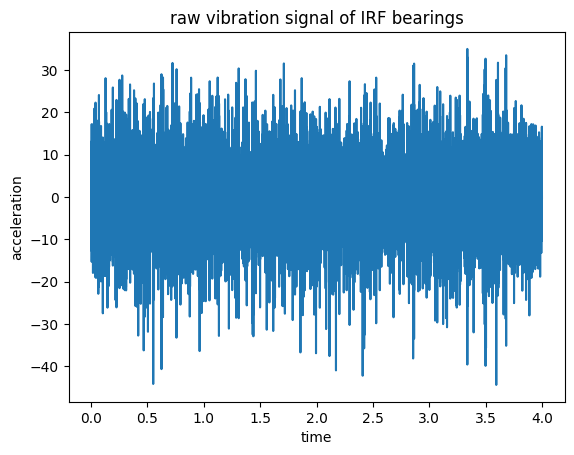

In [6]:
#this is the plot for the original vibration signals for the IRF bearings
plt.plot(time_vec,signal)
plt.xlabel("time"); plt.ylabel("acceleration")
plt.title("raw vibration signal of IRF bearings")
plt.show()

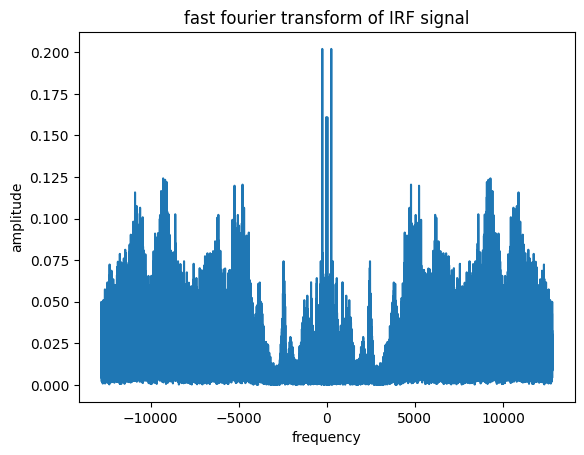

In [7]:
amplitude = np.abs(signal_fft)*2/n #the multiplying by 2 then dividing by the number is to scale the amplitude to the right size
plt.plot(sample_freq,amplitude) 
plt.xlabel("frequency"); plt.ylabel("amplitude")
plt.title("fast fourier transform of IRF signal")
plt.show()

In [8]:
threshold = 4000 #frequency threshold above which is considered noise
signal_fft_filtered, filtered_signal = fft_filter(signal_fft, sample_freq, threshold)

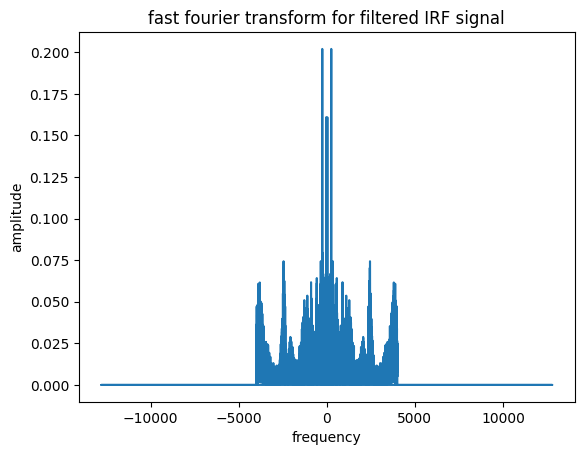

In [9]:
plt.plot(sample_freq,np.abs(signal_fft_filtered)*2/n) 
plt.xlabel("frequency"); plt.ylabel("amplitude")
plt.title("fast fourier transform for filtered IRF signal")
plt.show()

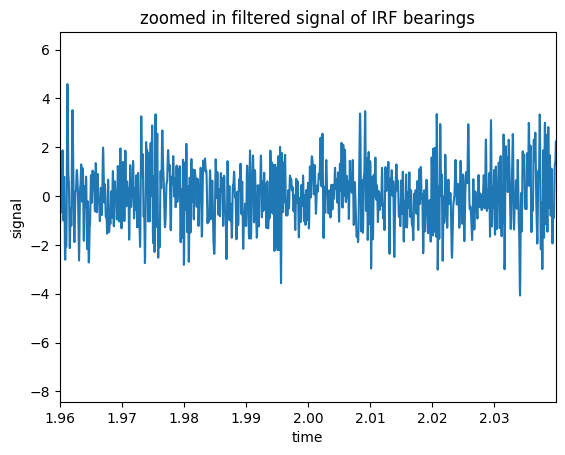

In [10]:
plt.plot(time_vec,filtered_signal)
plt.margins(x=-0.49, y=0) 
plt.xlabel("time"); plt.ylabel("signal")
plt.title("zoomed in filtered signal of IRF bearings")
plt.show()

In [11]:
filtered_signal_reshaped = np.reshape(filtered_signal, (-1,array_feature_size)) 

In [12]:
feature_array = feature_extraction(filtered_signal_reshaped, IRF=True)

In [13]:
time_vec_BF, signal_BF = decompose_from_filename(BF_filename)
n_BF = time_vec_BF.size
signal_BF_fft = fftpack.fft(signal_BF)
sample_freq_BF = fftpack.fftfreq(signal_BF.size, d=time_step)

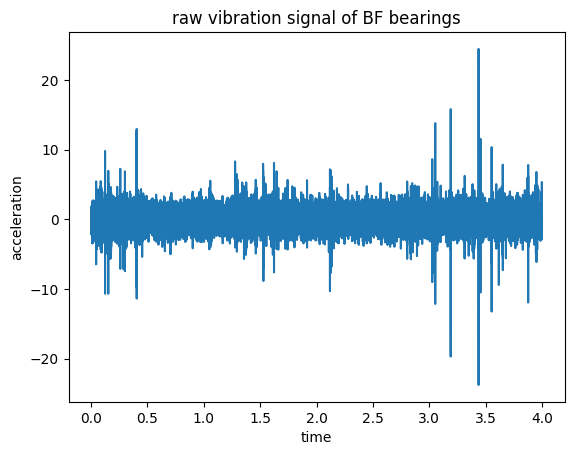

In [14]:
#this is the plot for the original vibration signals for the BF bearings
plt.plot(time_vec_BF,signal_BF)
plt.xlabel("time"); plt.ylabel("acceleration")
plt.title("raw vibration signal of BF bearings")
plt.show()

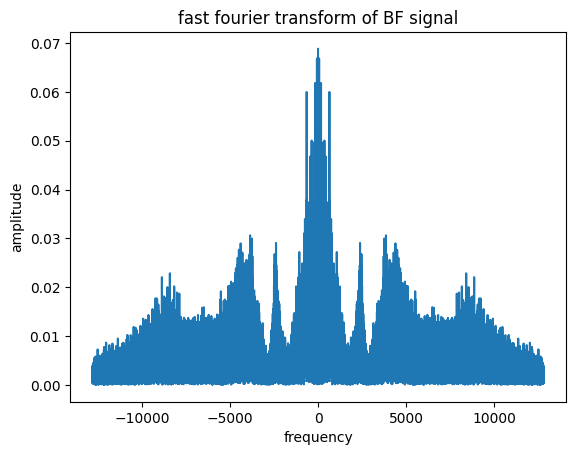

In [15]:
amplitude_BF = np.abs(signal_BF_fft)*2/n_BF 
plt.plot(sample_freq_BF,amplitude_BF) 
plt.xlabel("frequency"); plt.ylabel("amplitude")
plt.title("fast fourier transform of BF signal")
plt.show()

In [16]:
signal_BF_fft_filtered, filtered_signal_BF = fft_filter(signal_BF_fft, sample_freq_BF, threshold)

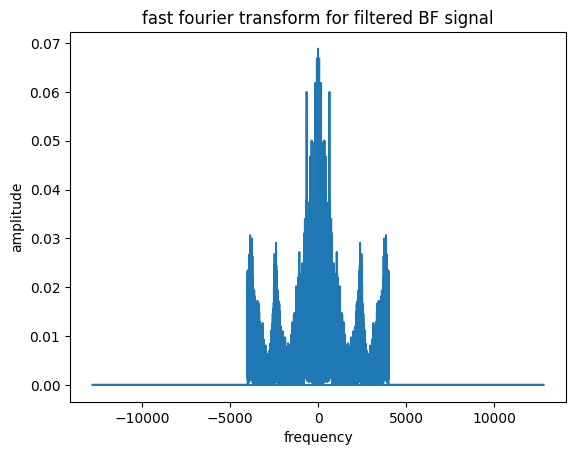

In [17]:
plt.plot(sample_freq_BF,np.abs(signal_BF_fft_filtered)*2/n_BF) 
plt.xlabel("frequency"); plt.ylabel("amplitude")
plt.title("fast fourier transform for filtered BF signal")
plt.show()

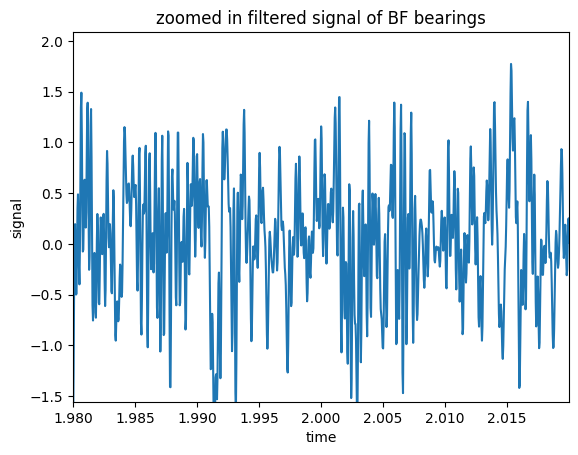

In [18]:
plt.plot(time_vec_BF,filtered_signal_BF)
plt.margins(x=-0.495, y=-0.4) 
plt.xlabel("time"); plt.ylabel("signal")
plt.title("zoomed in filtered signal of BF bearings")
plt.show()

In [19]:
filtered_signal_BF_reshaped = np.reshape(filtered_signal_BF, (-1,array_feature_size))  
feature_array_BF = feature_extraction(filtered_signal_BF_reshaped, IRF=False)

In [20]:
dataset_array = np.concatenate((feature_array_BF, feature_array))
dataset_as_df = pd.DataFrame(dataset_array , columns= ['root mean square', 'skewness','mean', 'standard deviation', 'amplitude square','root amplitude' , 'class'])

In [21]:
#uncomment the lines to explore the dataframe
# dataset_as_df.head()
# dataset_as_df.shape
# dataset_as_df.size
# dataset_as_df.count()
# dataset_as_df['class'].value_counts()

c:\Users\OmarAbdelgawad\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


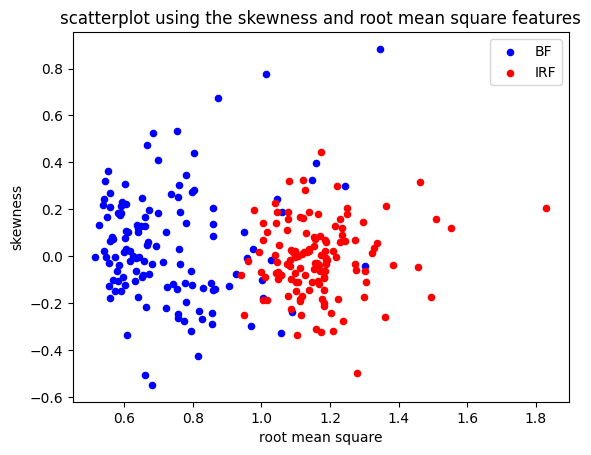

In [22]:
#the following code is for showing the distribution of the dataset as a scatter plot (only skewness vs root mean square)
BF_df = dataset_as_df[dataset_as_df['class'] == 0]#[0,128]
IRF_df = dataset_as_df[dataset_as_df['class'] == 1]#[0,128]
axes = BF_df.plot(kind='scatter',x='root mean square',y='skewness',color='blue', label='BF')
IRF_df.plot(kind='scatter',x='root mean square',y='skewness',color='red', label='IRF', ax=axes)
plt.title("scatterplot using the skewness and root mean square features")
plt.show()
#help(BF_df.plot)

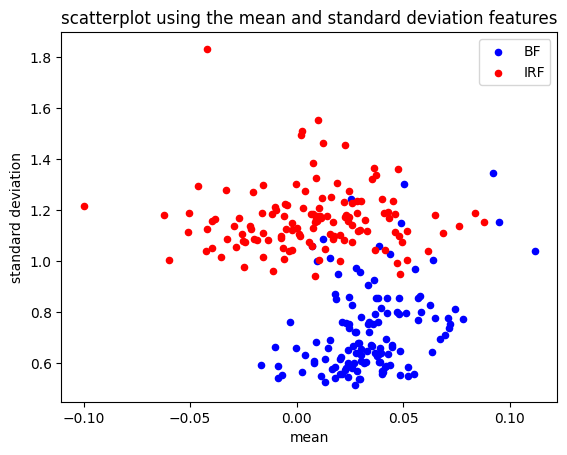

In [23]:
axes_2 = BF_df.plot(kind='scatter',x='mean',y='standard deviation',color='blue', label='BF')
IRF_df.plot(kind='scatter',x='mean',y='standard deviation',color='red', label='IRF',ax=axes_2)
plt.title("scatterplot using the mean and standard deviation features")
plt.show()

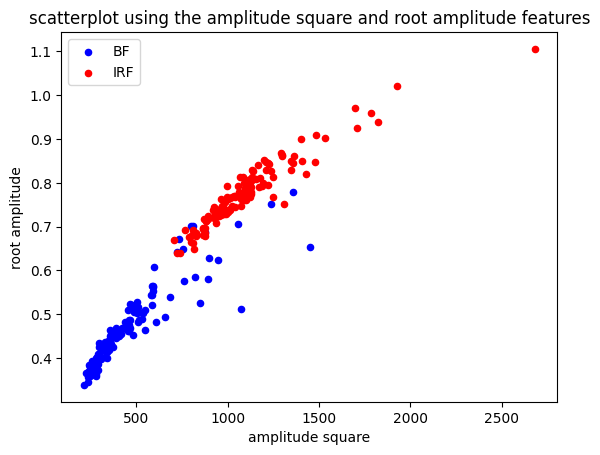

In [24]:
axes_3 = BF_df.plot(kind='scatter',x='amplitude square',y='root amplitude',color='blue', label='BF')
IRF_df.plot(kind='scatter',x='amplitude square',y='root amplitude',color='red', label='IRF',ax=axes_3)
plt.title("scatterplot using the amplitude square and root amplitude features")
plt.show()

In [25]:
feature_df = dataset_as_df.loc[:,dataset_as_df.columns!='class']
#independent variable x
x = feature_df

#dependent variable y 
label_df = dataset_as_df['class']
y = label_df

In [26]:
print(f'x has shape {x.shape}')
print(f'y has shape {y.shape}')

x has shape (256, 6)
y has shape (256,)


In [27]:
#dividing the data as train/test data
'''
dataset(256rows)-->train(200rows)/test(56rows)
train (x,y) #note that x is a two dimensional array while y is a 1 dimensional array
test (x,y)
'''
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.21875, random_state= 4)
#200 x 6
print(x_train.shape)
#200 x 1
print(y_train.shape)
#56 x 6
print(x_test.shape)
#56 x 1
print(y_test.shape)

print(type(x_train))

(200, 6)
(200,)
(56, 6)
(56,)
<class 'pandas.core.frame.DataFrame'>


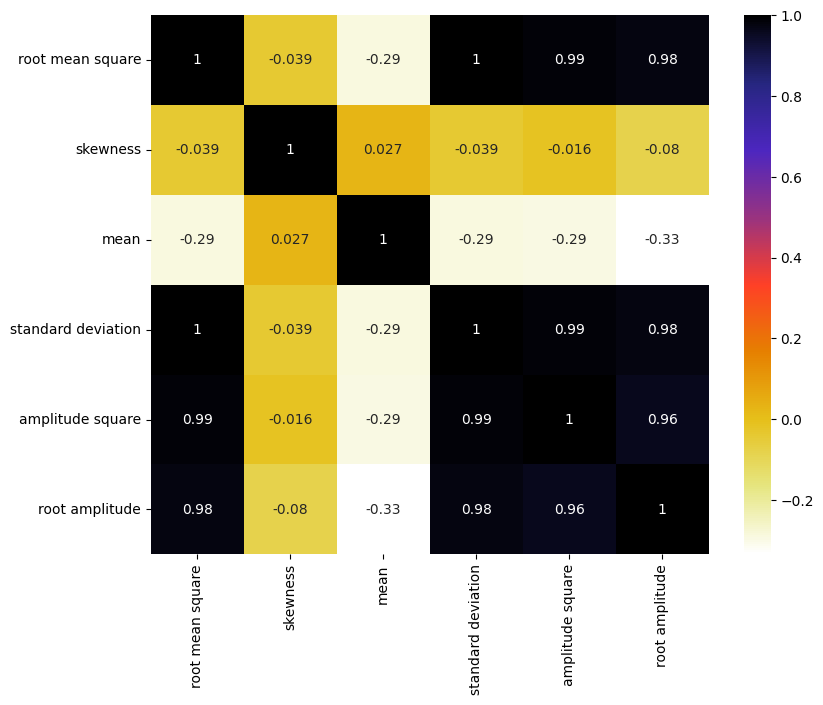

In [28]:
#using pearson correlation
plt.figure(figsize=(9,7))
cor = x_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

# Dropping Correlated Features
Since we want to differentiate between the two classes we will drop the engineered features which have a correlation higher than a certain threshold. This ensures that the model will use the features that are probably different depending the class type.

In [29]:
corr_features = correlation_thresh(x_train,0.8)
print(len(corr_features))
print(corr_features)

3
{'standard deviation', 'amplitude square', 'root amplitude'}


In [30]:
x_train_new = x_train.drop(corr_features, axis=1)
x_test_new = x_test.drop(corr_features, axis=1)

x_train_new_normalized = preprocessing.normalize(x_train_new, axis = 0)
x_test_new_normalized = preprocessing.normalize(x_test_new, axis = 0)

In [31]:
#finally this is the modeling part using the svm
classifier = svm.SVC(kernel='linear', gamma='auto', C=2)
classifier.fit(x_train_new_normalized, y_train)
y_predict = classifier.predict(x_test_new_normalized)

In [32]:
#Evaluation of the results
final = classification_report(y_test, y_predict)
print(final)

              precision    recall  f1-score   support

         0.0       0.76      0.89      0.82        28
         1.0       0.87      0.71      0.78        28

    accuracy                           0.80        56
   macro avg       0.81      0.80      0.80        56
weighted avg       0.81      0.80      0.80        56



In [33]:
accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

0.8035714285714286


In [34]:
cm = confusion_matrix(y_test, y_predict)
print(cm)

[[25  3]
 [ 8 20]]


In [35]:
def supp_vec_fault_diag(filename):
    time_vec, signal = decompose_from_filename(filename)
    time_step = find_time_step(time_vec)
    n = time_vec.size
    signal_fft = fftpack.fft(signal)
    sample_freq = fftpack.fftfreq(signal.size, d=time_step)

    signal_copy, filtered_signal = fft_filter(signal_fft, sample_freq, threshold)
    filtered_signal_reshaped = np.reshape(filtered_signal, (-1,array_feature_size))

    full_features_arr = feature_extraction(filtered_signal_reshaped, IRF=True)[:,:-1] #last col is label
    feature_array = full_features_arr[:,:3] #first three are the uncorrelated features
    dataset_as_df = pd.DataFrame(feature_array , columns= ['root mean square', 'skewness','mean'])
    dataset_as_df_normalized = preprocessing.normalize(dataset_as_df, axis = 0)
    y_predict = classifier.predict(dataset_as_df_normalized)
    a = np.ones(y_predict.shape[0])
    confidence = accuracy_score(a, y_predict)
    answer = statistics.mode(y_predict)
    if answer == 1:
        answer = ("Inner Race Fault")
    else:
        answer = ("Ball Fault")
    return answer, max(confidence, 1-confidence)

In [36]:
filename_test = "dataset used for testing\BF HL 830 rpm.csv"
supp_vec_fault_diag(filename_test)

('Ball Fault', 0.6328125)

In [37]:
filename_test = "dataset used for testing\IRF HL 877 rpm.csv"
supp_vec_fault_diag(filename_test)

('Inner Race Fault', 0.546875)